# Import Dependencies

In [1]:
import tensorflow as tf
import os

# Make sure thet tensorflow dosen't take up whole GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# Clean Up Data
### Import Dependencies

In [4]:
import cv2
import imghdr

### Configure Directory

In [5]:
data_dir = 'data'

### Make a list for acceptable extentions

In [6]:
img_ext = ['jpg','jpeg','png','bmp']

### Apply the extension cleanup script

In [7]:
for image_class in os.listdir(data_dir): #Go through all the folders
    for image in os.listdir(os.path.join(data_dir, image_class)): #go through subfolders
        image_path = os.path.join(data_dir, image_class, image) #grab all the images
        try:
            img = cv2.imread(image_path) #loads image
            tip = imghdr.what(image_path) #reads extension
            if tip not in img_ext: #if extension not in the list
                os.remove(image_path) #delete the image
        except Exception as E:
            print('Problem')

# Load data using Keras

### Import Numpy and PyPlot

In [8]:
import numpy as np
from matplotlib import pyplot as plt

### Generate dataset usig keras

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data') #automatically reshapes all the images

Found 486 files belonging to 2 classes.


### Convert to numpy iterator to Catch data on the fly

In [10]:
data_iterator = data.as_numpy_iterator() #access data pipeline

In [11]:
batch = data_iterator.next() # The next() function returns the next batch in an iterator. 

### Visualize one batch of data

In [12]:
batch[0].shape
batch[1]

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

### we see that the labels of 0 and 1. To find which is which we plot the data.

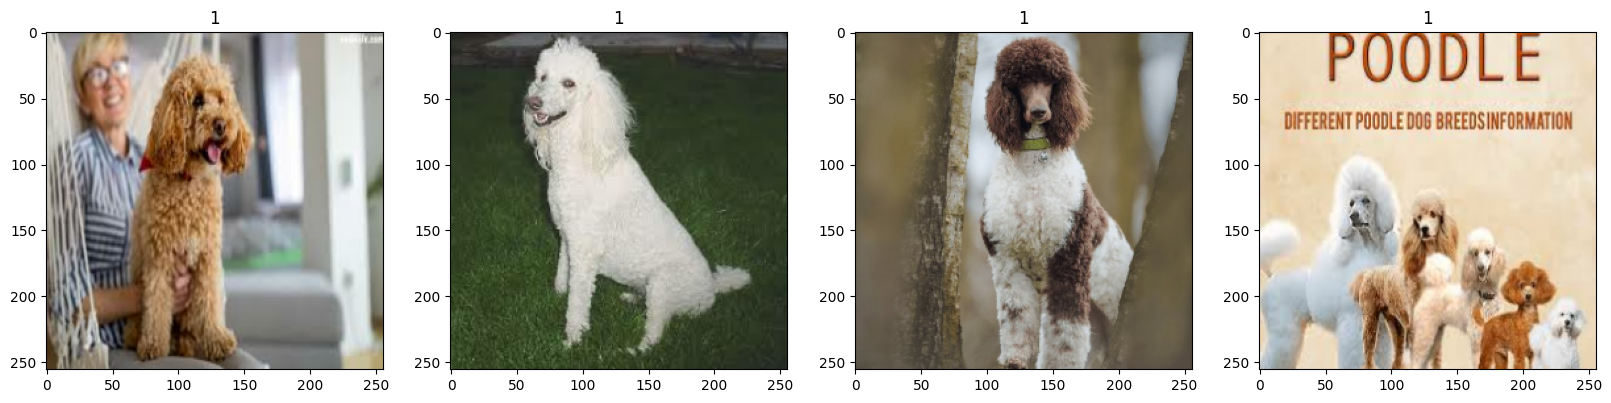

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### we see that 1 is poodle and 0 is German Shephard

# Preprocessing Data
#### 1. Normalize the values between 0 and 1
#### 2. Split the data among training, testing and validation set

# Scaling Images

In [14]:
scaled_data = data.map(lambda x, y: (x/255,y) ) #transformation step on data pipelinne

In [15]:
scaled_iterator = scaled_data.as_numpy_iterator() #again transform the scaled data into numpy iterator
batch = scaled_iterator.next() #next batch of iterators
batch[0].max() #verifying the scaled data

1.0

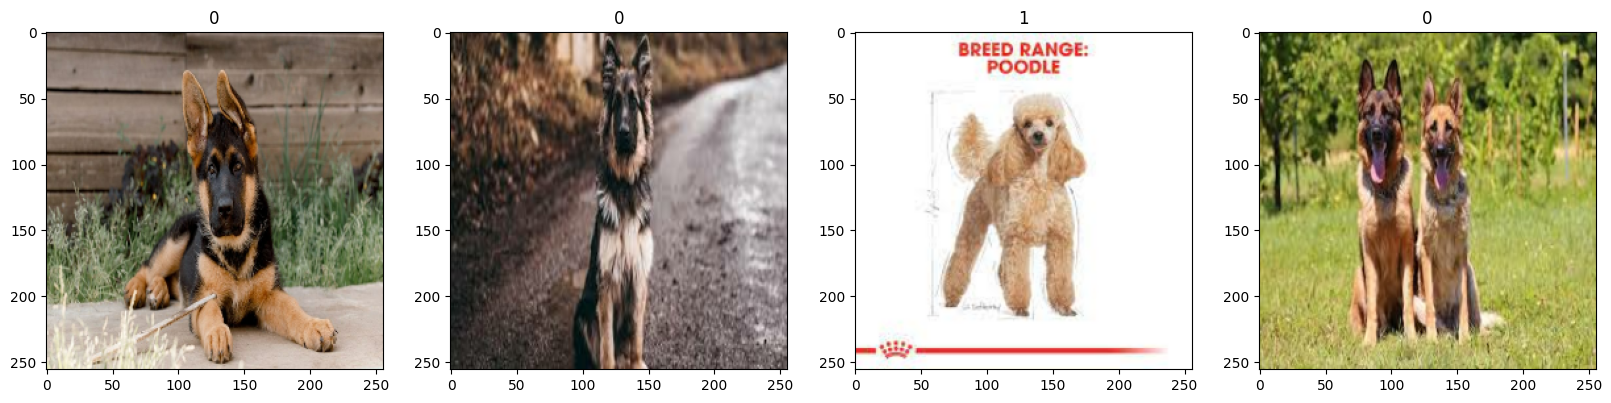

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

# Partitioning Dataset

### Split the data into training, validation and test set

In [17]:
train_size = int(len(scaled_data)*0.7) #70% is used to train the model
val_size = int(len(scaled_data)*0.2)+1  #20% is used to validate the model on the fly
test_size = int(len(scaled_data)*0.1) #10% is used to test the model AFTER training

In [18]:
len(scaled_data)

16

In [19]:
print(train_size) 
print(val_size) 
print(test_size) #make sure they add up to the size of actual batches of data

11
4
1


In [20]:
train = scaled_data.take(train_size) #Creates a Dataset with at most count elements from this dataset.
val = scaled_data.skip(train_size).take(val_size) #Creates a Dataset that skips count elements from this dataset.
test = scaled_data.skip(train_size + val_size).take(test_size)

# Building the network model

### Import Keras modules

In [21]:
from keras.models import Sequential #one input and one output
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten  #CNN layers for image processing

### Build model using Sequential API

In [22]:
model = Sequential()

### I'll add the layers line by line in order to make it easier to debug

In [23]:
model.add(Conv2D(32,(3,3),1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(265, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Tried softgel but the accuracy was poor, so using sigmoid now


### Compile the model

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), #because there's only 2 options ,so we use BinaryCrossEntrophy
              metrics=['accuracy'])

### Architecture of the model

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

# Training the model

### We'll define the log file directory

In [26]:
logdir='logs'

### Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

In [27]:
 tensorboard_callbacks =  tf.keras.callbacks.TensorBoard(logdir)

In [28]:
hist = model.fit(train,  batch_size=10, epochs=30, verbose=2,validation_data=val, callbacks=[tensorboard_callbacks] )      

Epoch 1/30
11/11 - 22s - loss: 0.6934 - accuracy: 0.5199 - val_loss: 0.6793 - val_accuracy: 0.5469 - 22s/epoch - 2s/step
Epoch 2/30
11/11 - 35s - loss: 0.6815 - accuracy: 0.5824 - val_loss: 0.6752 - val_accuracy: 0.6250 - 35s/epoch - 3s/step
Epoch 3/30
11/11 - 48s - loss: 0.6774 - accuracy: 0.5881 - val_loss: 0.6678 - val_accuracy: 0.6953 - 48s/epoch - 4s/step
Epoch 4/30
11/11 - 53s - loss: 0.6666 - accuracy: 0.6193 - val_loss: 0.6515 - val_accuracy: 0.7344 - 53s/epoch - 5s/step
Epoch 5/30
11/11 - 38s - loss: 0.6543 - accuracy: 0.6790 - val_loss: 0.6546 - val_accuracy: 0.6406 - 38s/epoch - 3s/step
Epoch 6/30
11/11 - 46s - loss: 0.6334 - accuracy: 0.7045 - val_loss: 0.6486 - val_accuracy: 0.6250 - 46s/epoch - 4s/step
Epoch 7/30
11/11 - 37s - loss: 0.6194 - accuracy: 0.6705 - val_loss: 0.6231 - val_accuracy: 0.6406 - 37s/epoch - 3s/step
Epoch 8/30
11/11 - 51s - loss: 0.6274 - accuracy: 0.6619 - val_loss: 0.5948 - val_accuracy: 0.7422 - 51s/epoch - 5s/step
Epoch 9/30
11/11 - 45s - loss: 0

# Plotting performance graph

### Graph for loss

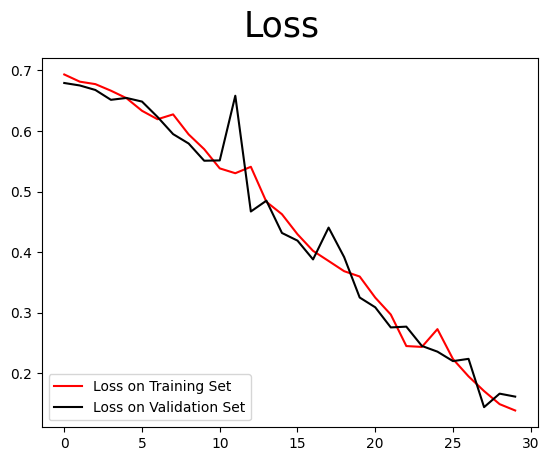

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Loss on Training Set')
plt.plot(hist.history['val_loss'], color='black', label='Loss on Validation Set')
fig.suptitle('Loss', fontsize=25)
plt.legend(loc="lower left")
plt.show()

###  Graph for accuracy

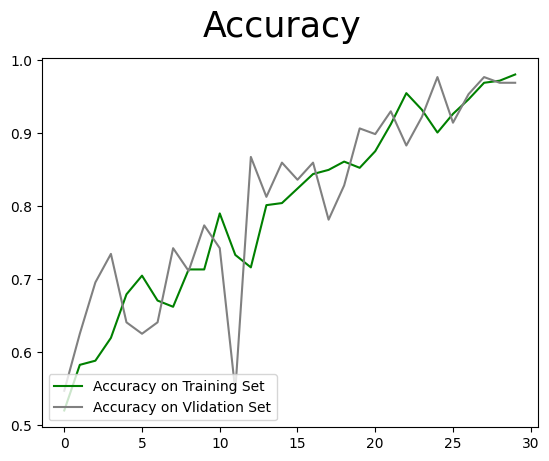

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='Accuracy on Training Set')
plt.plot(hist.history['val_accuracy'], color='gray', label='Accuracy on Vlidation Set')
fig.suptitle('Accuracy', fontsize=25)
plt.legend(loc="lower left")
plt.show()

# Evaluating on test set

### Evaluating performance

In [31]:
from tensorflow.keras.metrics import Precision, Recall , BinaryAccuracy

In [32]:
pre = Precision() #Computes the precision of the predictions with respect to the labels.
re = Recall()  #Computes the recall of the predictions with respect to the labels.
ba = BinaryAccuracy() #Calculates how often predictions match binary labels.

In [33]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    ba.update_state(y, yhat)

1/1 [==============================] - 0s 238ms/step


In [34]:
print(pre.result(), re.result(), ba.result()) #we see that they have the highest value

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# Evaluating on new set

### Import opencv

In [35]:
import cv2

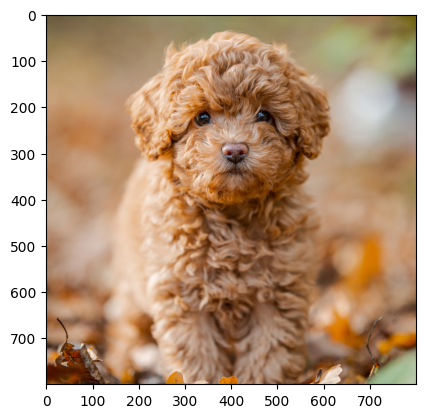

In [36]:
img = cv2.imread('poodle-miniature-toy3.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

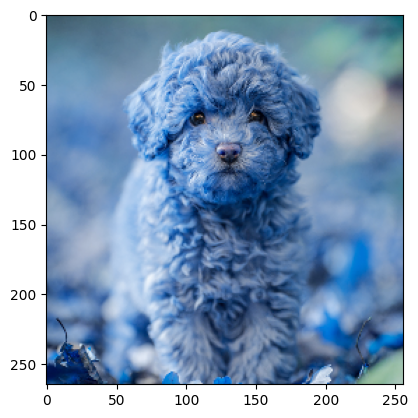

In [37]:
resized_image = tf.image.resize(
    img,
    (265,256),
    
)
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resized_image/255, 0))
if yhat > 0.8: 
    print(f'Predicted class is Poodle')
else:
    print(f'Predicted class is German Shephard')

1/1 [==============================] - 0s 130ms/step
Predicted class is German Shephard


# Saving the model

### we'll save the model using keras load model api

In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow import keras

In [45]:
model.save(os.path.join('models','dog_classifier.h5'))

In [46]:
new_model = keras.models.load_model('models/dog_classifier.h5')

### We'll verify from the summary

In [47]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0